## Problem Statement
To design and build CNN model for identification of Dysarthria disease
Data:
https://www.kaggle.com/datasets/iamhungundji/dysarthria-detection
Create a Kaggle notebook in this dataset. Perform all the tasks in this notebook.
Task:
1. Read data.csv in pandas
2. For any 1 random sample of dysarthric male, dysarthric female, non-dysarthric male, and
non-dysarthric female, visualize
a. Waveplot
b. Spectrogram
c. Zero Crossing rate
d. Spectral Centroid and rolloff,
e. MFCC
f. Mel Spectrogram
3. Comment on the output.
4. Define a function to create 256 MFCC features for any given audio file.
5. Split the data into training and validation by a ratio of 90:10.
6. Build the CNN model with padding on a training set.
7. Evaluate the validation set.
8. Calculate and comment on ROC AUC score, recall score and confusion matrix.

In [56]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from sklearn.preprocessing import minmax_scale
import IPython.display as ipd

plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 16
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")

In [57]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [58]:
!pip install --upgrade librosa

In [ ]:
import os

# Set Kaggle API credentials path
os.environ['KAGGLE_CONFIG_DIR'] = '/root/.kaggle/'

# Download the dataset
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess
kaggle datasets download -d iamhungundji/dysarthria-detection

# Unzip the downloaded file
!unzip -q '*.zip' -d data

In [59]:
directory = '/content/data/input/dysarthria-detection'
data = pd.read_csv("/content/data/input/dysarthria-detection/torgo_data/data.csv")
data['filename'] = data['filename'].apply(lambda x: os.path.join(directory,x))
data

,is_dysarthria,gender,filename
0,non_dysarthria,female,/content/data/input/dysarthria-detection/torgo...
1,non_dysarthria,female,/content/data/input/dysarthria-detection/torgo...
2,non_dysarthria,female,/content/data/input/dysarthria-detection/torgo...
3,non_dysarthria,female,/content/data/input/dysarthria-detection/torgo...
4,non_dysarthria,female,/content/data/input/dysarthria-detection/torgo...
...,...,...,...
1995,dysarthria,male,/content/data/input/dysarthria-detection/torgo...
1996,dysarthria,male,/content/data/input/dysarthria-detection/torgo...
1997,dysarthria,male,/content/data/input/dysarthria-detection/torgo...
1998,dysarthria,male,/content/data/input/dysarthria-detection/torgo...


In [60]:
data.head()

,is_dysarthria,gender,filename
0,non_dysarthria,female,/content/data/input/dysarthria-detection/torgo...
1,non_dysarthria,female,/content/data/input/dysarthria-detection/torgo...
2,non_dysarthria,female,/content/data/input/dysarthria-detection/torgo...
3,non_dysarthria,female,/content/data/input/dysarthria-detection/torgo...
4,non_dysarthria,female,/content/data/input/dysarthria-detection/torgo...


In [74]:
def show_waveplot(audio_path,label,gender):
    x , sr = librosa.load(audio_path)
    plt.figure(figsize=(20, 6))
    librosa.display.waveshow(x, sr=sr)
    plt.title(f"Waveplot: of Class: {label}, Gender: {gender}")

def show_spectrogram(audio_path,label,gender):
    x , sr = librosa.load(audio_path)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(20,6))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz',cmap='plasma')
    plt.colorbar()
    plt.title(f"Spectrogram of Class: {label}, Gender: {gender}")

def show_zcr(audio_path,label,gender):
    x , sr = librosa.load(audio_path)
    zero_crossings = librosa.zero_crossings(x)
    print("Sum of zero crossing ", zero_crossings.sum())
    plt.figure(figsize=(20, 5))
    plt.title(f'Zero Crossing Rate of Class: {label}, Gender: {gender}')
    zcrs = librosa.feature.zero_crossing_rate(x)
    plt.plot(zcrs[0])
    plt.show()

def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)

def show_spectral_centroids(audio_path,label,gender):
    plt.figure(figsize=(20, 5))
    plt.title(f'Spectral Centroids of Class: {label}, Gender: {gender}')
    x , sr = librosa.load(audio_path)
    spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)
    librosa.display.waveshow(x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_centroids), color='r')
    plt.show()

def show_spectral_rolloff(audio_path,label,gender):
    plt.figure(figsize=(20, 5))
    plt.title(f'Spectral Rolloff of Class: {label}, Gender: {gender}')
    x , sr = librosa.load(audio_path)
    spectral_rolloff = librosa.feature.spectral_rolloff(x, sr=sr, roll_percent=0.01)[0]
    frames = range(len(spectral_rolloff))
    t = librosa.frames_to_time(frames)
    librosa.display.waveshow(x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_rolloff), color='r')
    plt.show()


def show_mfccs(audio_path,label,gender):
    plt.figure(figsize=(20, 6))
    plt.title(f'MFCC of Class: {label}, Gender: {gender}')
    x , sr = librosa.load(audio_path)
    mfccs = librosa.feature.mfcc(y=x, sr=sr)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time',cmap='plasma')
    plt.show()

def show_melspectro(audio_path,label,gender):
    plt.figure(figsize=(20, 6))
    plt.title(f'Mel Spectro of Class: {label}, Gender: {gender}')
    x , sr = librosa.load(audio_path)
    melspectro = librosa.feature.melspectrogram(y=x, sr=sr)
    librosa.display.specshow(melspectro, sr=sr, x_axis='time',cmap='plasma')
    plt.show()

In [62]:
data.sample(frac=1).reset_index(drop=True,inplace=True)
male_dysarthric = data[(data['gender']=='male') & (data['is_dysarthria']=='dysarthria')].sample(1)
female_dysarthric = data[(data['gender']=='female') & (data['is_dysarthria']=='dysarthria')].sample(1)
male_ndysarthric = data[(data['gender']=='male') & (data['is_dysarthria']=='non_dysarthria')].sample(1)
female_ndysarthric = data[(data['gender']=='female') & (data['is_dysarthria']=='non_dysarthria')].sample(1)

In [63]:
ipd.Audio(male_dysarthric.iloc[0].filename)

In [64]:
ipd.Audio(female_dysarthric.iloc[0].filename)

In [65]:
ipd.Audio(male_ndysarthric.iloc[0].filename)

In [66]:
ipd.Audio(female_ndysarthric.iloc[0].filename)

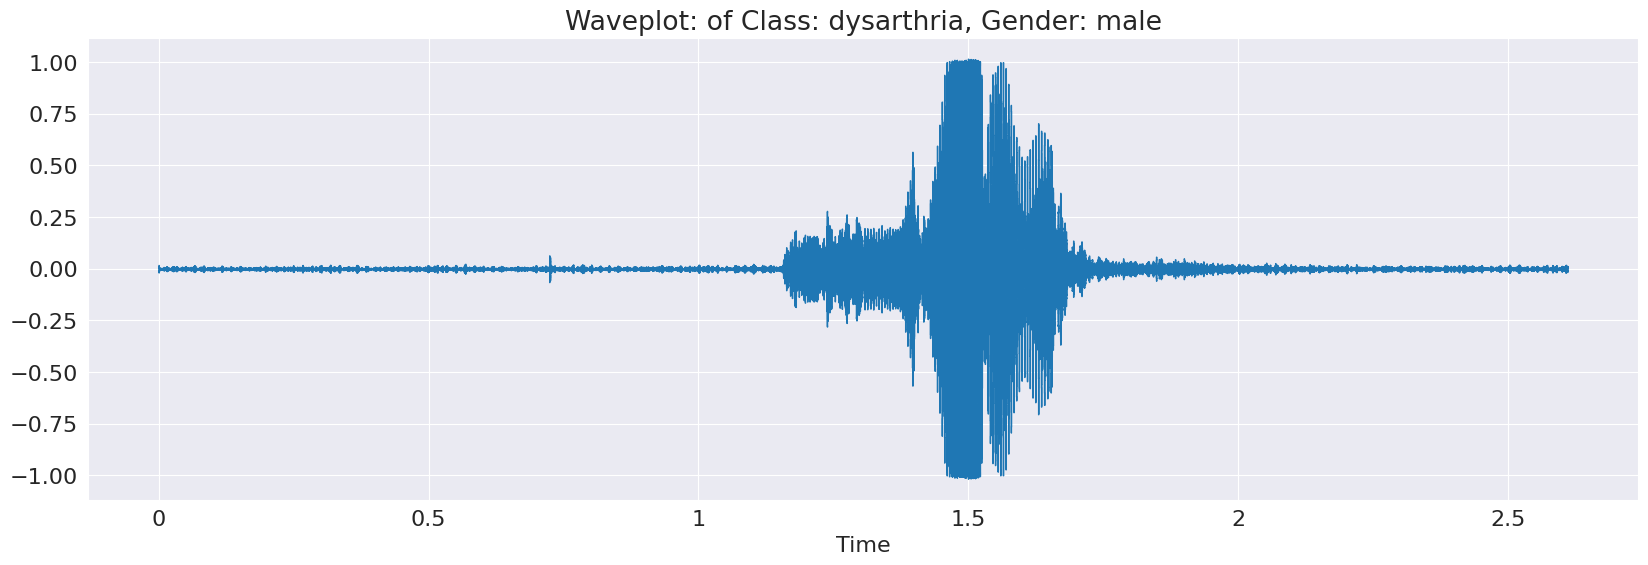

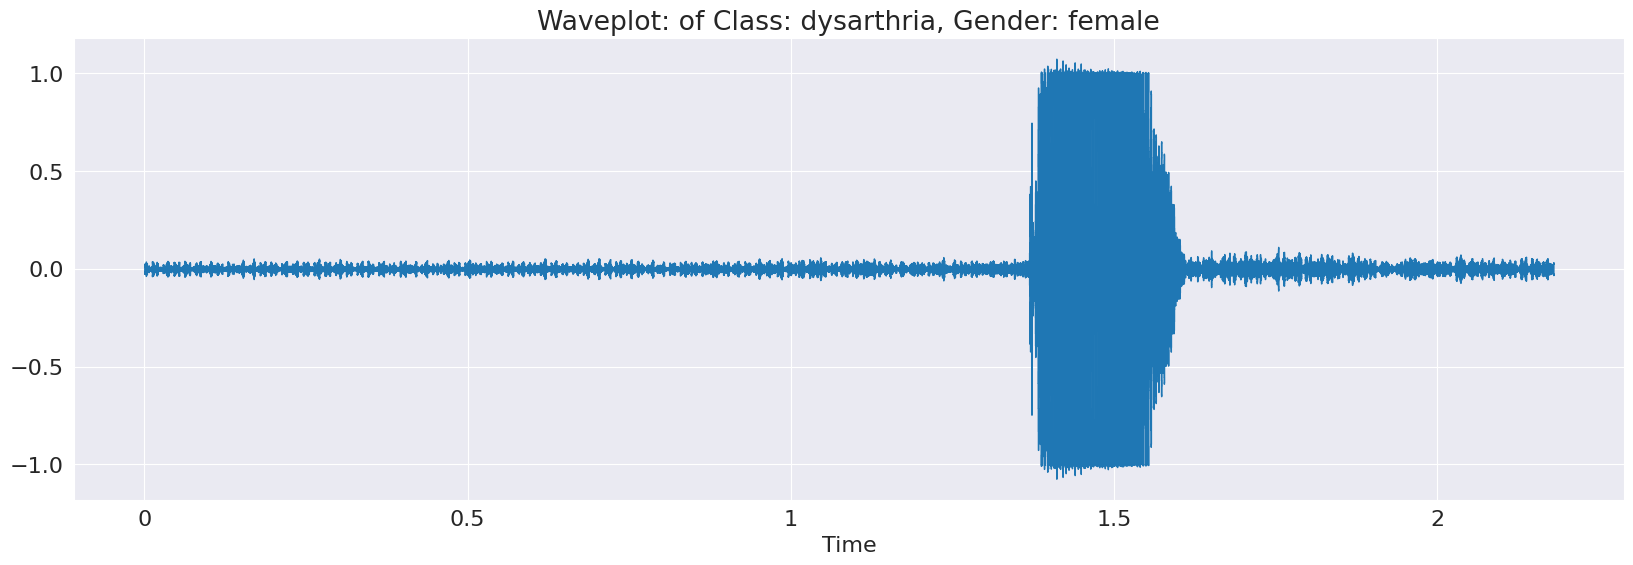

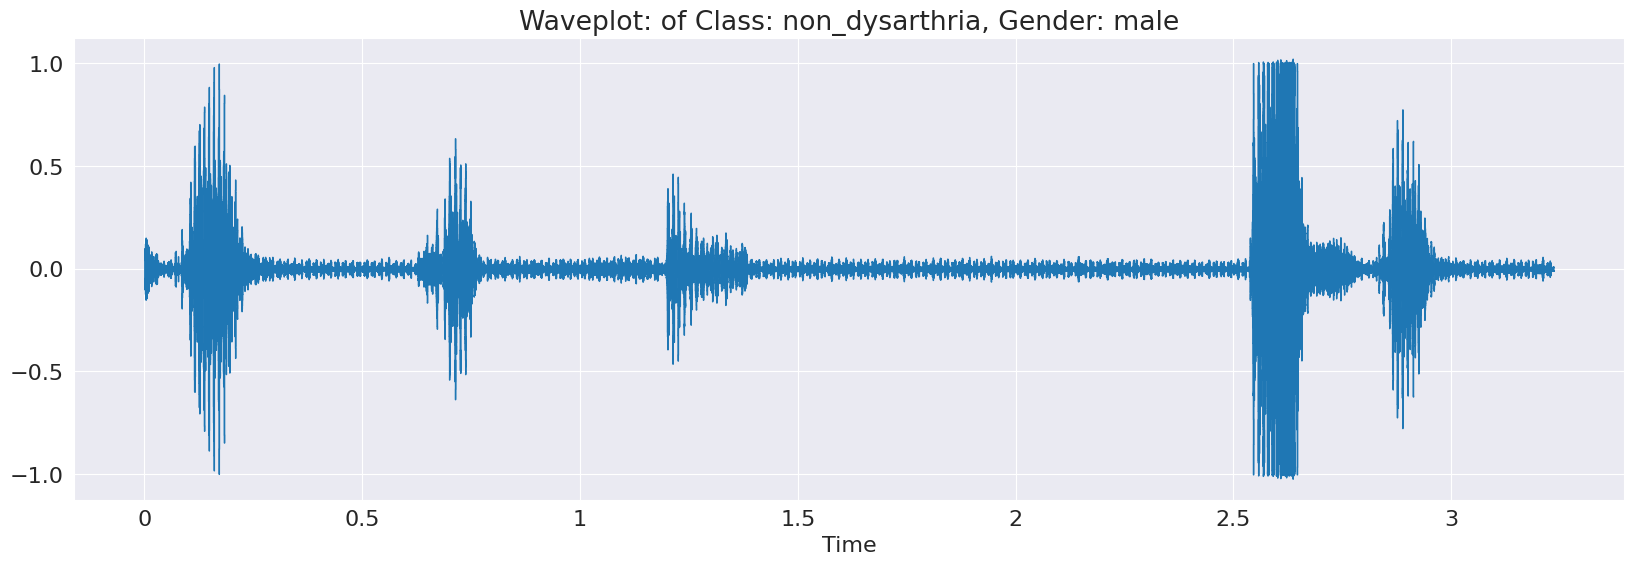

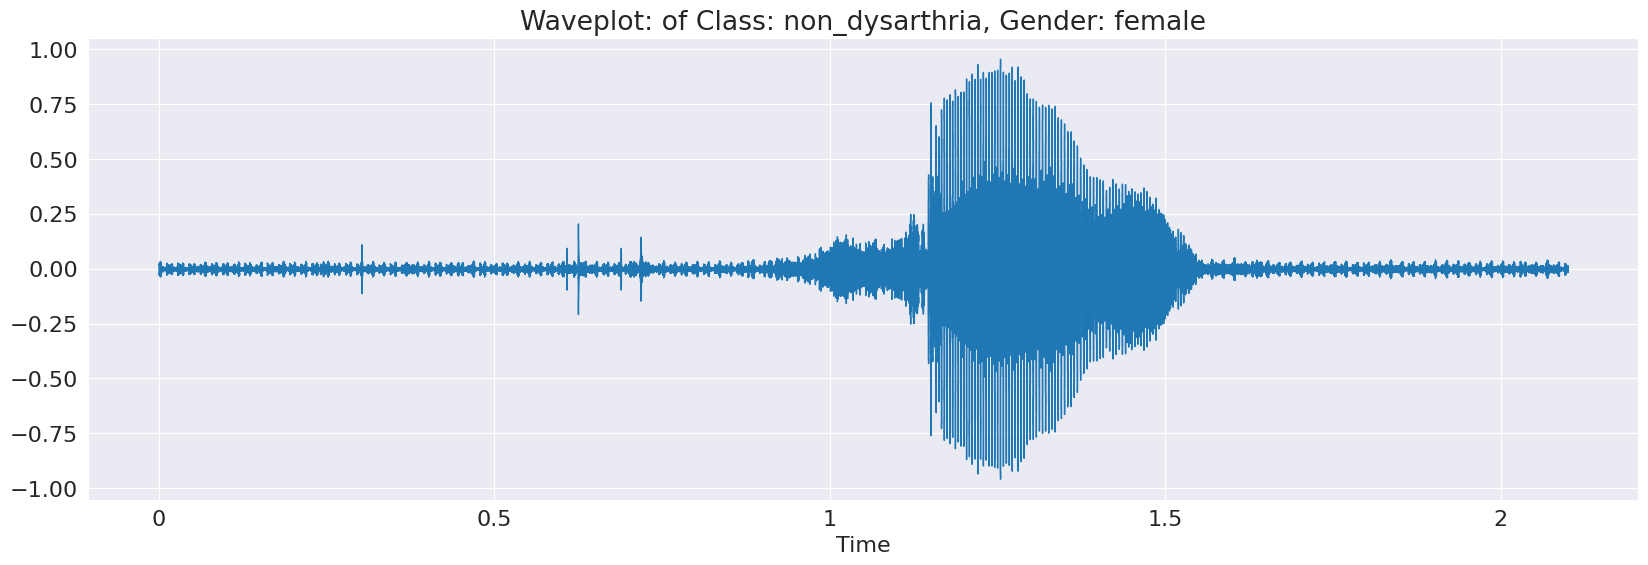

In [67]:
show_waveplot(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
show_waveplot(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
show_waveplot(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
show_waveplot(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)

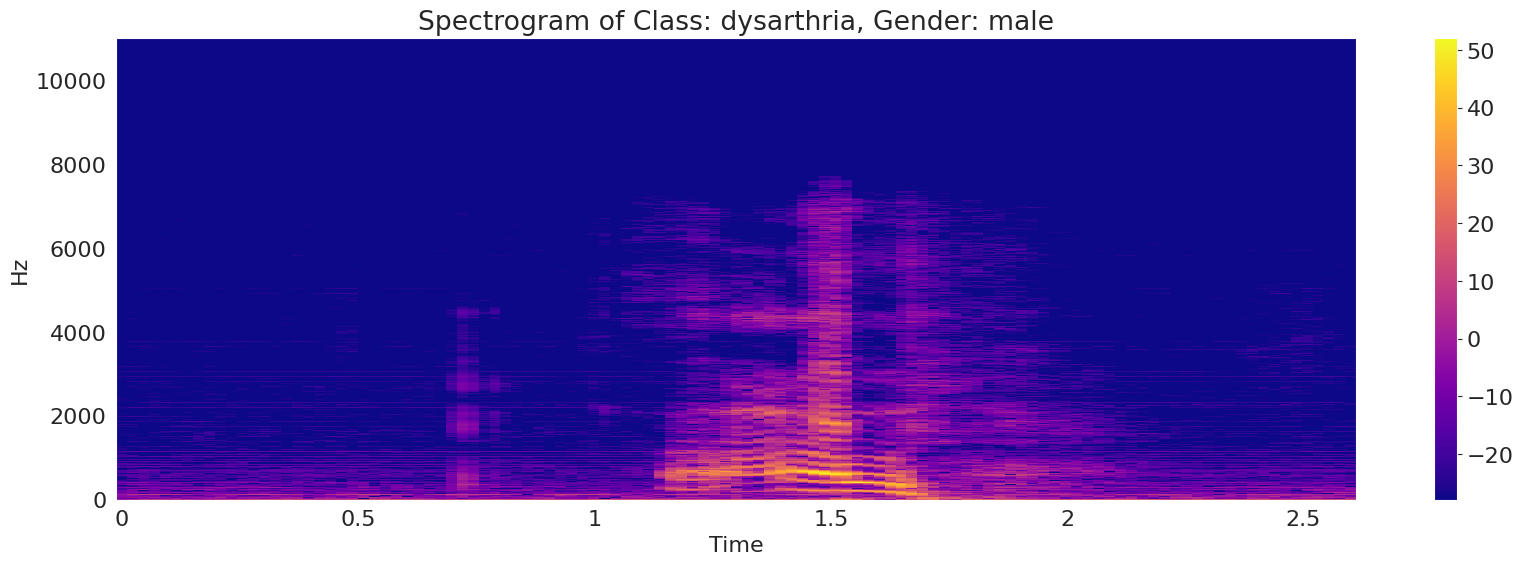

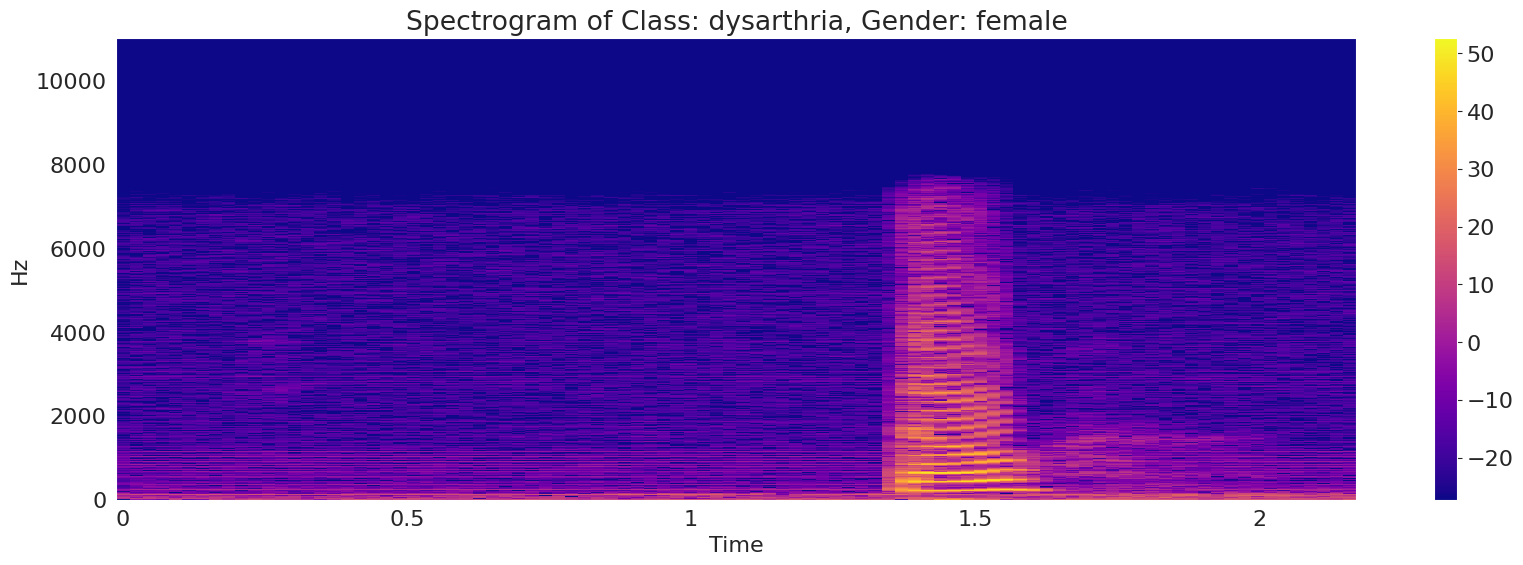

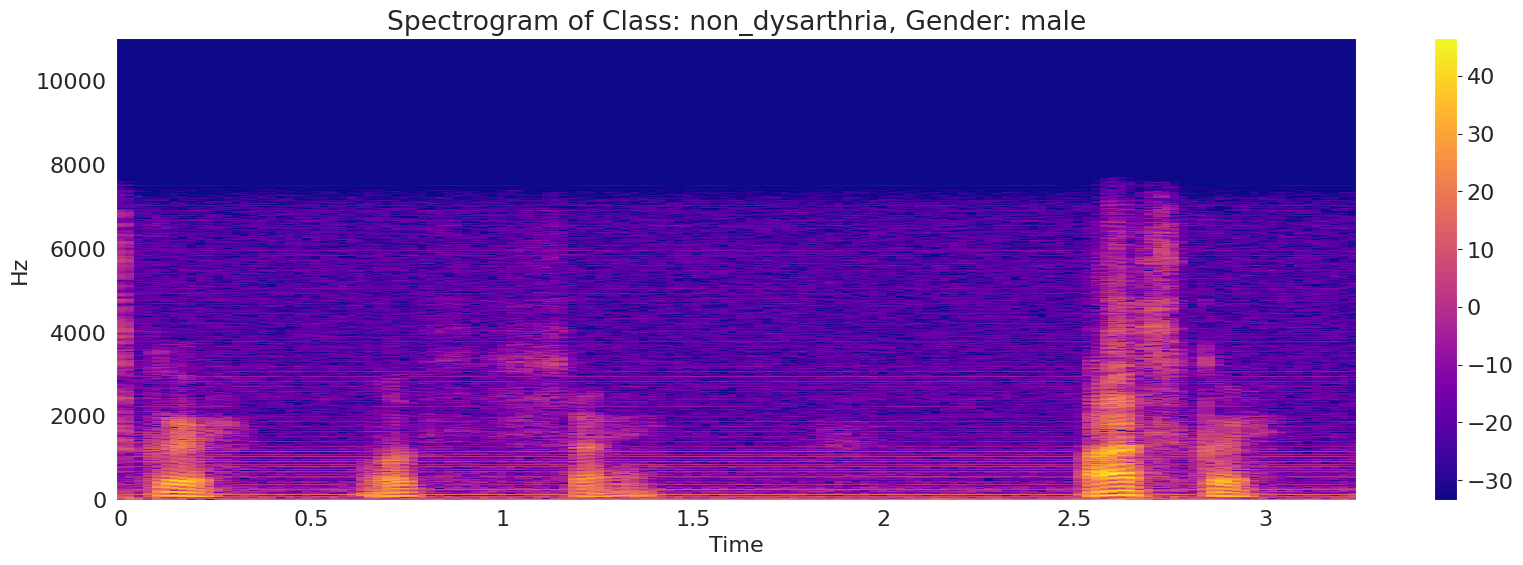

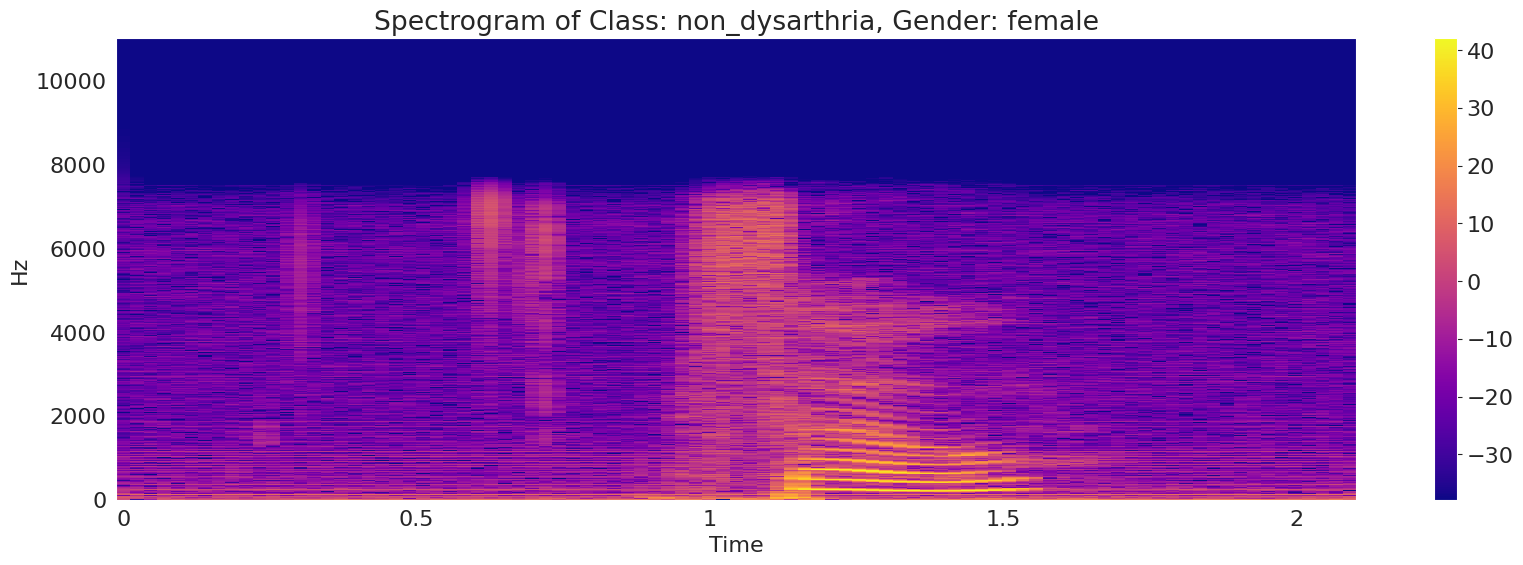

In [68]:
show_spectrogram(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
show_spectrogram(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
show_spectrogram(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
show_spectrogram(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)

Sum of zero crossing  2576


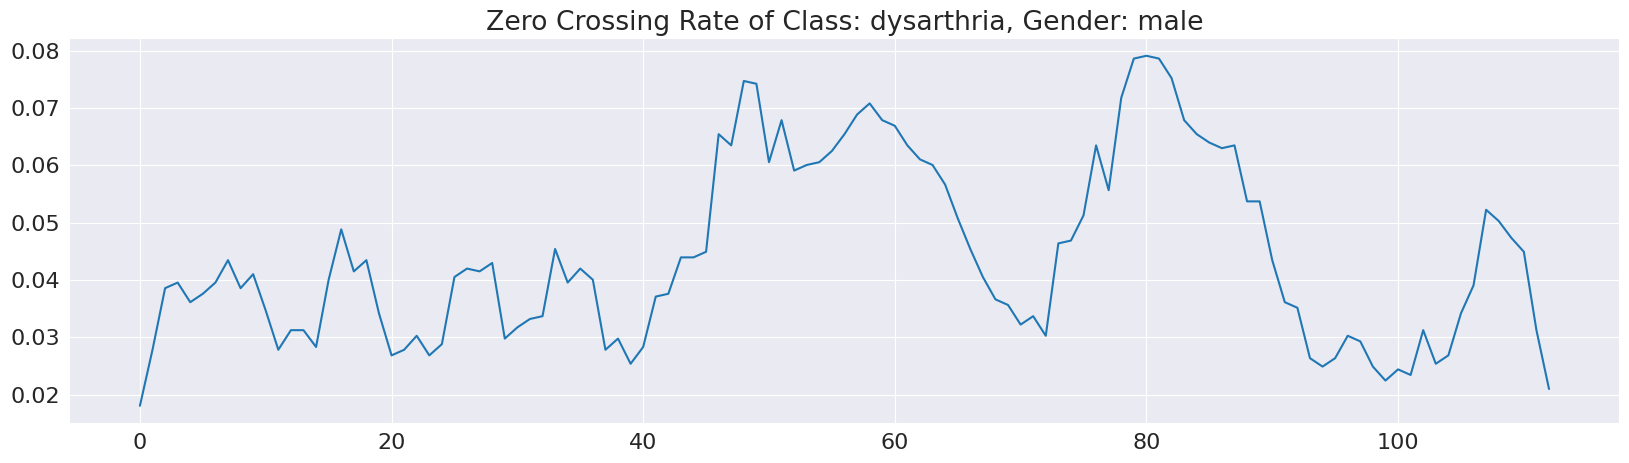

Sum of zero crossing  2974


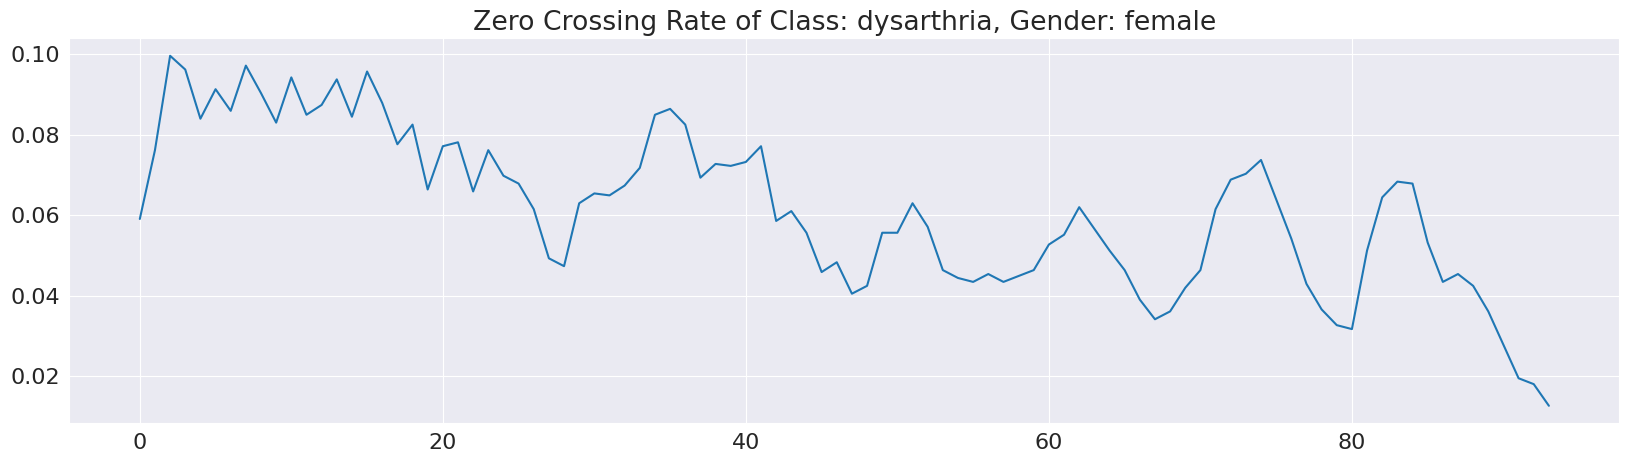

Sum of zero crossing  4946


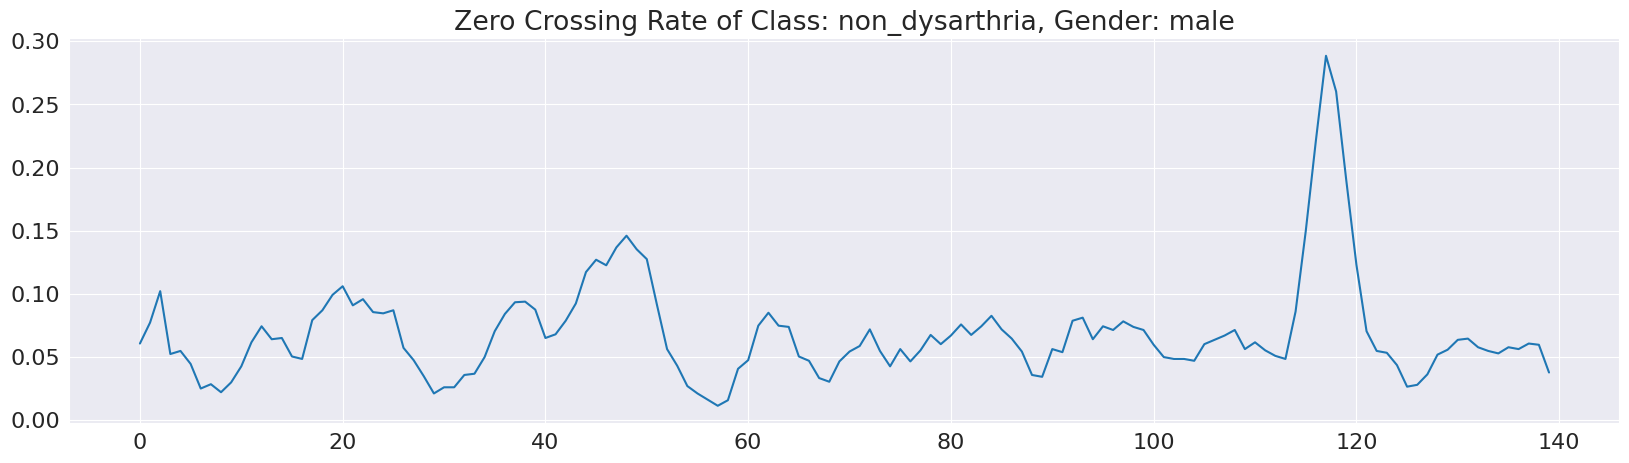

Sum of zero crossing  4783


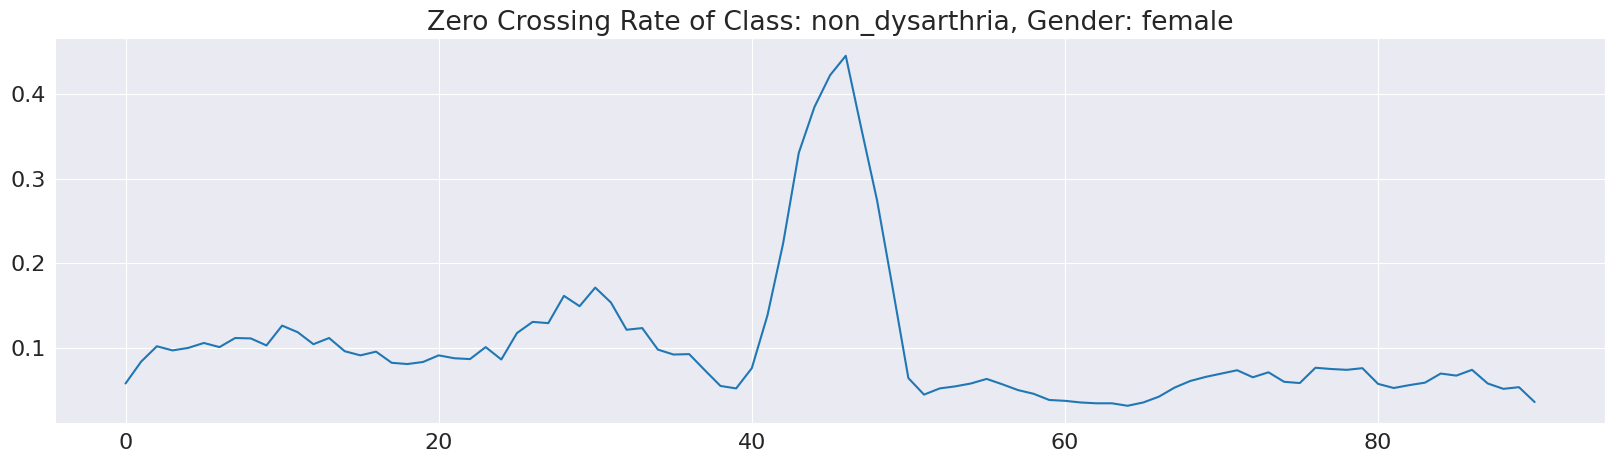

In [69]:
show_zcr(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
show_zcr(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
show_zcr(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
show_zcr(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)

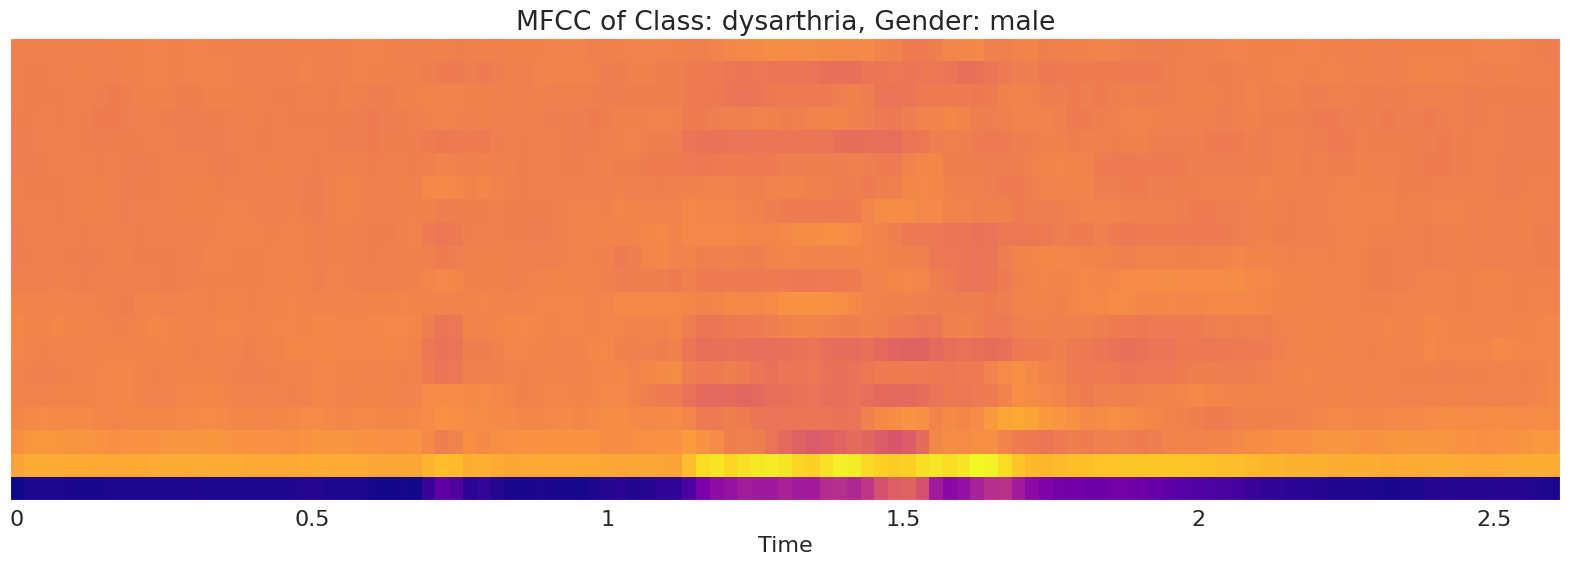

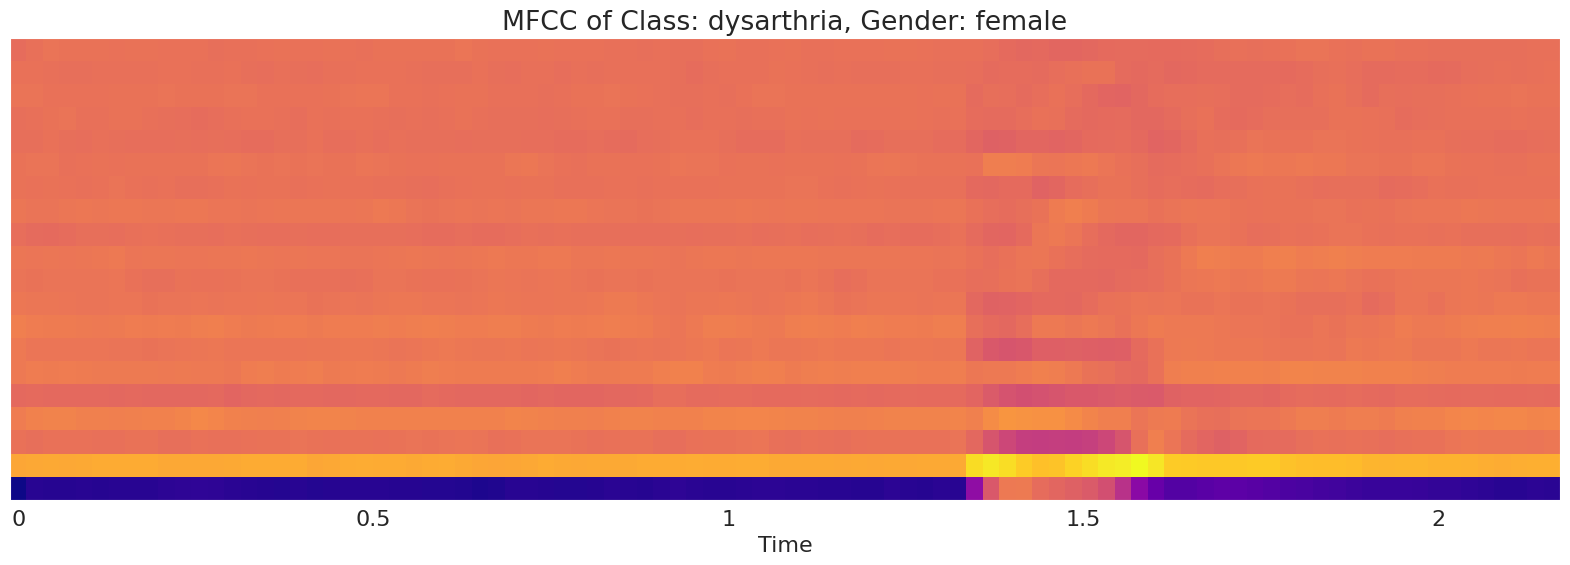

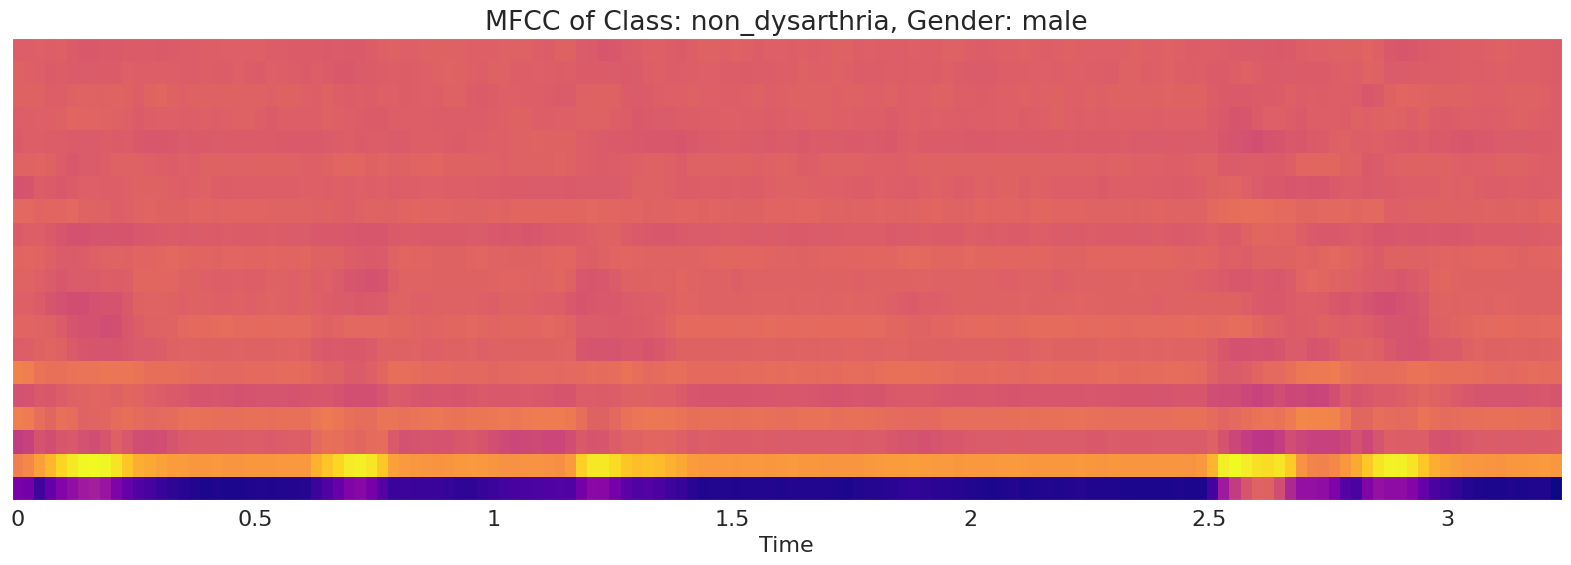

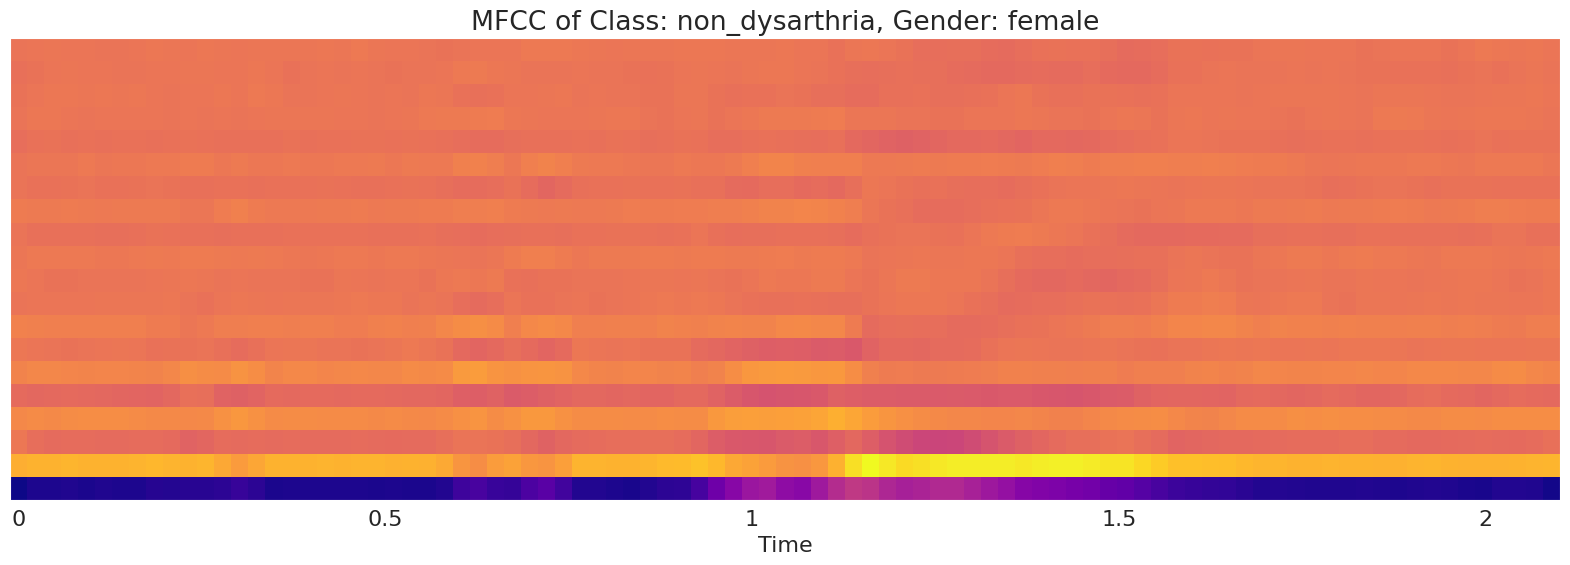

In [77]:
show_mfccs(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
show_mfccs(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
show_mfccs(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
show_mfccs(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)

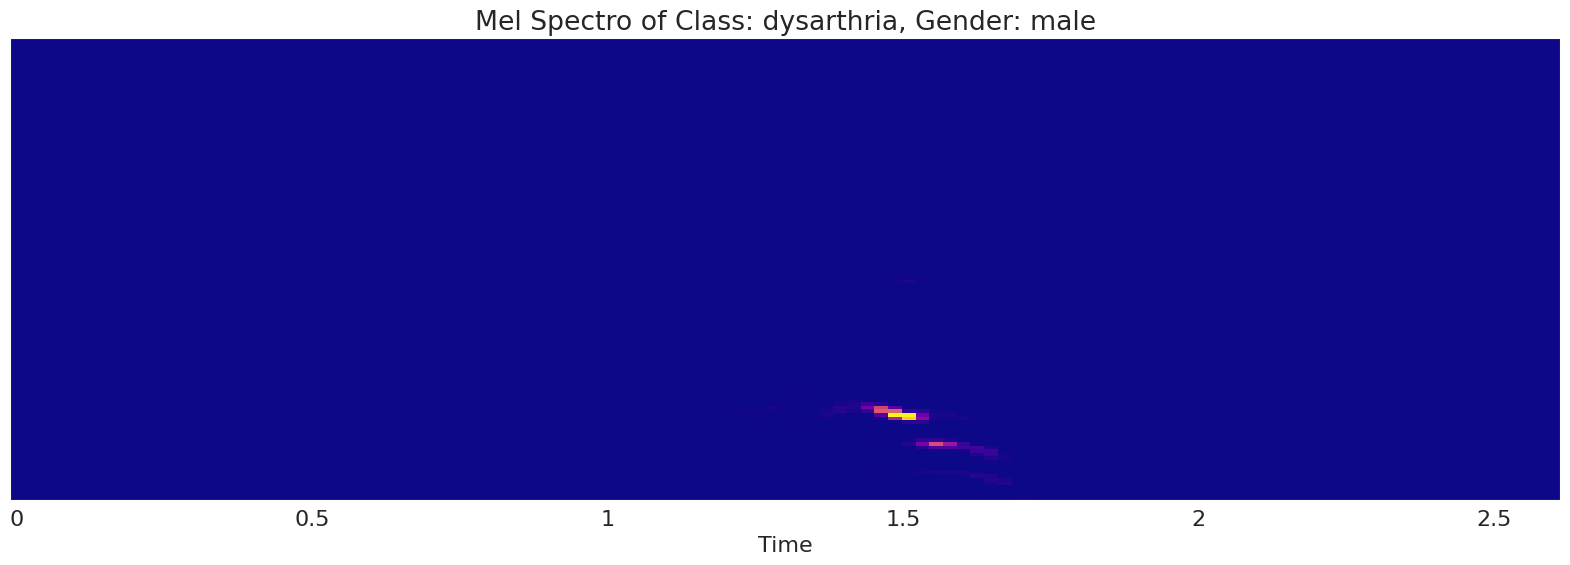

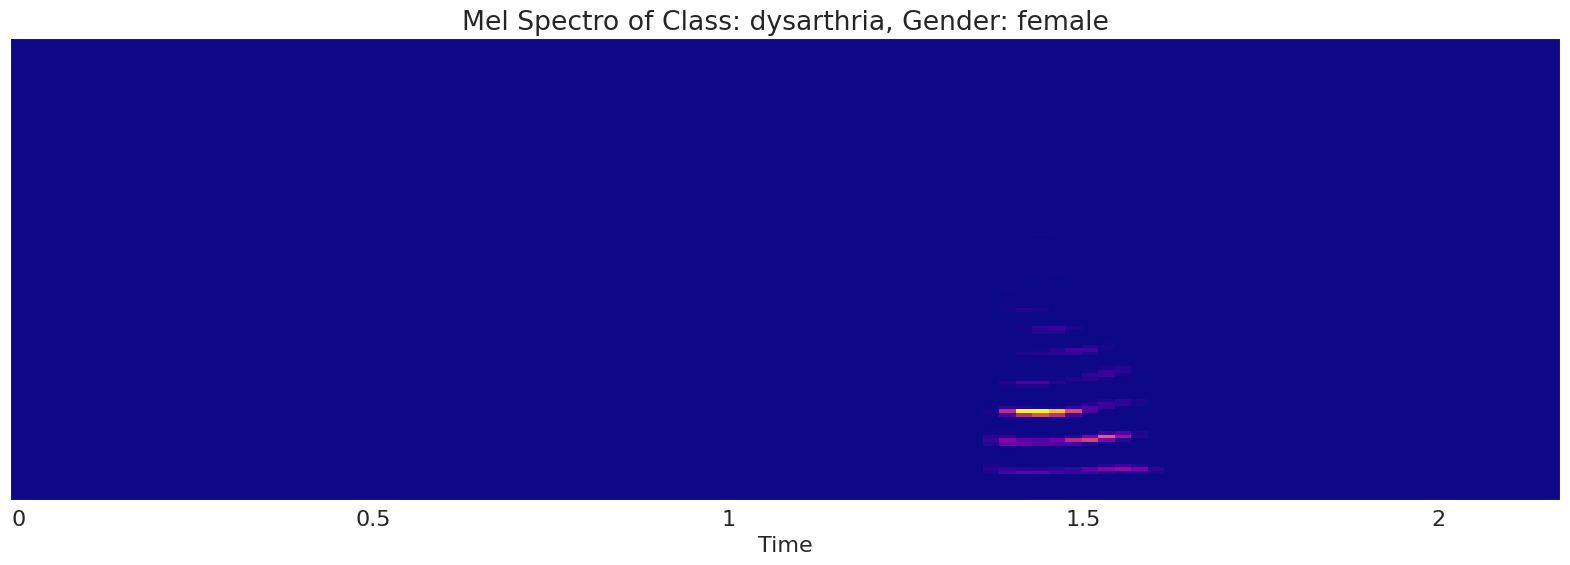

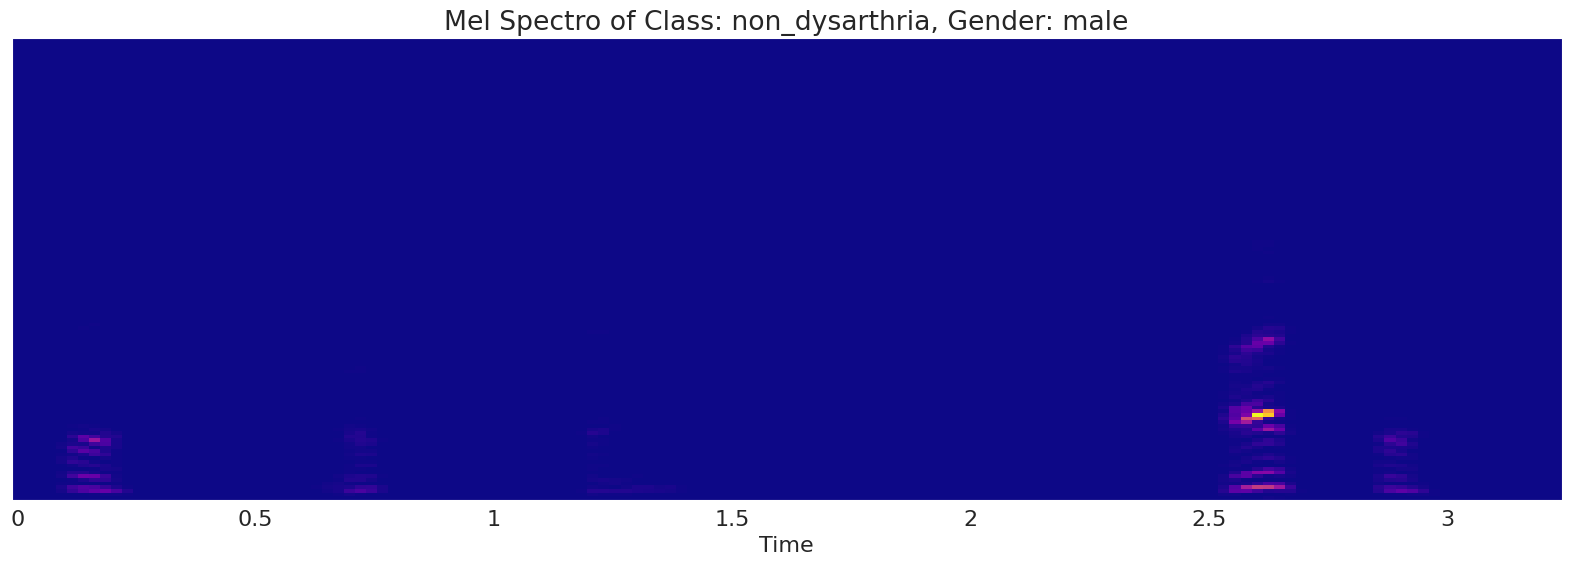

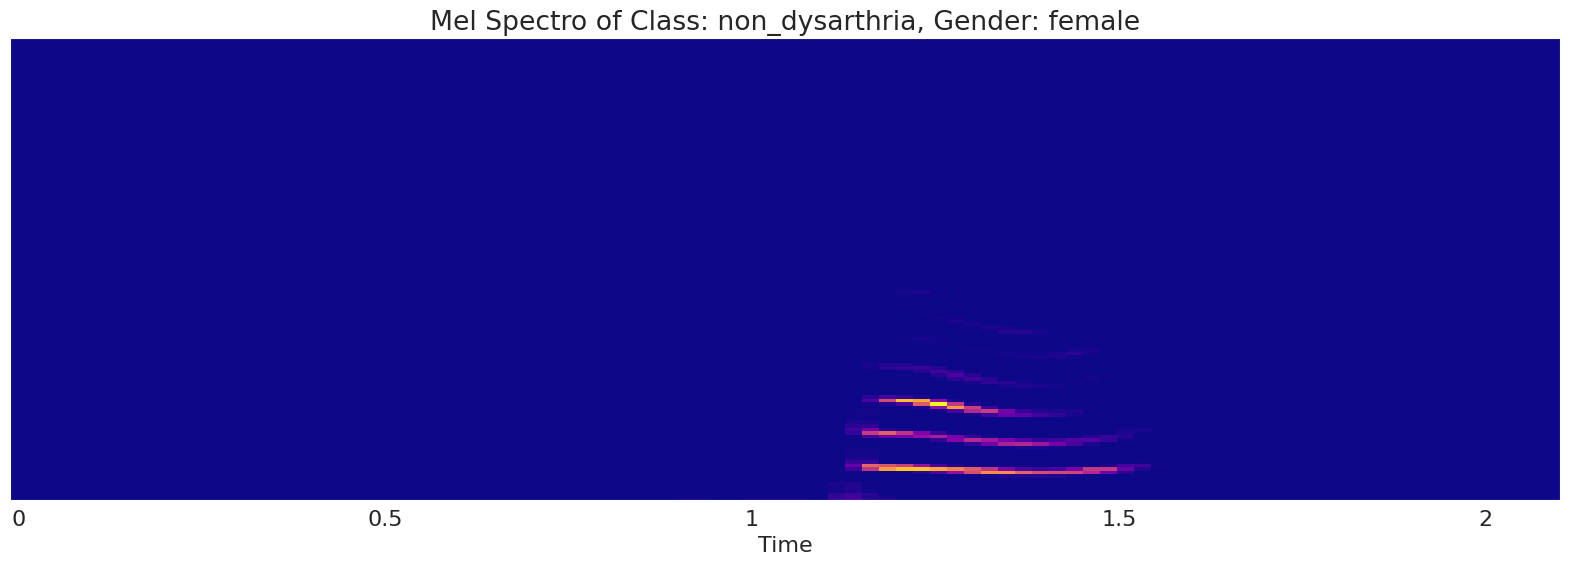

In [80]:
show_melspectro(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
show_melspectro(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
show_melspectro(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
show_melspectro(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)

In [81]:
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, recall_score

In [82]:
def feature_extraction(df):
    features = []
    for i,record in tqdm(df.iterrows(),total=df.shape[0]):
        try:
            x , sr = librosa.load(record['filename'])
            mean_mfcc = np.mean(librosa.feature.mfcc(y=x, sr=sr, n_mfcc=128),axis=1)
            features.append(mean_mfcc)
        except EOFError:
            pass

    dataf = pd.DataFrame(features)
    dataf['class'] = df['is_dysarthria']
    return dataf

In [83]:
dataf = feature_extraction(data)

100%|██████████| 2000/2000 [00:47<00:00, 41.67it/s]


In [84]:
dataf

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,class
0,-221.788269,101.259232,-16.548132,38.492065,-13.595653,20.772554,-5.536349,10.410690,1.962461,-0.799047,...,0.962193,0.744855,1.058080,0.388451,0.081758,0.546172,0.594357,0.170033,-0.219215,non_dysarthria
1,-299.520081,109.872574,-17.097269,38.854969,-16.881130,22.959133,1.824228,18.724188,3.448541,4.455822,...,1.105589,1.056284,1.252576,0.027333,-1.368948,-0.037859,0.020661,-0.082124,-0.744832,non_dysarthria
2,-302.950043,112.048477,-23.679882,44.887413,-22.434727,26.299335,0.811477,18.210291,4.344697,4.912156,...,0.844332,0.530004,1.018391,0.055385,-1.472088,0.295324,0.191228,-0.224301,-0.582725,non_dysarthria
3,-210.861603,116.504486,-35.046494,37.670425,-27.112516,25.593727,-7.511986,13.140750,-0.587347,4.138087,...,0.630752,0.898457,0.721398,0.174576,-0.090706,0.001524,0.360464,-0.075448,-0.259715,non_dysarthria
4,-280.227203,104.505035,-17.209877,45.064884,-15.542122,28.115068,-3.449209,16.841436,4.573242,1.738296,...,1.596206,0.970084,0.732015,0.547593,-0.152664,0.131893,-0.288228,-0.468570,-0.461726,non_dysarthria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,-304.231995,115.359306,-0.794746,26.543352,-0.682190,13.183387,2.389222,4.290236,-1.372811,-2.624718,...,0.473923,0.103740,0.311737,0.015566,-0.055351,0.193023,0.332826,0.014455,-0.221991,dysarthria
1995,-457.822144,110.087799,22.221985,-0.056086,-11.181323,3.190089,-4.499060,4.474746,5.809545,-1.913331,...,0.622933,0.508349,0.398737,0.455839,0.348571,0.286893,0.150862,-0.052999,0.001199,dysarthria
1996,-371.546875,116.846909,5.667272,22.488144,8.221014,7.740131,8.989120,9.996635,4.383992,3.590931,...,0.240280,-0.009779,-0.018253,-0.014393,-0.263360,0.556257,0.749682,-0.283888,-0.398581,dysarthria
1997,-302.500702,112.511192,-4.506540,32.498363,-1.519380,4.109807,4.611475,9.744307,-2.962905,-3.497744,...,0.146675,-0.200982,0.388719,0.160434,-0.383473,0.417755,1.042827,-0.082762,-0.111990,dysarthria


In [85]:
dataf.loc[dataf['class']=='non_dysarthria','class'] = 0.0
dataf.loc[dataf['class']=='dysarthria','class'] = 1.0
dataf['class'] = dataf['class'].astype(float)

X = dataf.iloc[:,:-1].values
y = dataf.iloc[:,-1]

In [86]:
X.shape, y.shape

((1999, 128), (1999,))

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
X_train = X_train.reshape(-1,16,8,1)
X_test = X_test.reshape(-1,16,8,1)

In [88]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [89]:
model = Sequential([
    InputLayer(input_shape=(16, 8, 1)),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = "same"),
    MaxPooling2D(2, 2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = "same"),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 8, 32)         320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 4, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 4, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 2, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 32)                1

In [90]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [91]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

In [92]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test,y_test), callbacks=[checkpoint,earlystopping])

Epoch 1/50
55/57 [===========================>..] - ETA: 0s - loss: 0.6093 - accuracy: 0.7034
Epoch 1: val_loss improved from inf to 0.40256, saving model to model.h5
57/57 [==============================] - 3s 17ms/step - loss: 0.6061 - accuracy: 0.7054 - val_loss: 0.4026 - val_accuracy: 0.8050
Epoch 2/50
53/57 [==========================>...] - ETA: 0s - loss: 0.3343 - accuracy: 0.8603
Epoch 2: val_loss did not improve from 0.40256
57/57 [==============================] - 1s 12ms/step - loss: 0.3341 - accuracy: 0.8599 - val_loss: 0.4630 - val_accuracy: 0.7650
Epoch 3/50
56/57 [============================>.] - ETA: 0s - loss: 0.2178 - accuracy: 0.9224
Epoch 3: val_loss improved from 0.40256 to 0.21026, saving model to model.h5
57/57 [==============================] - 1s 12ms/step - loss: 0.2172 - accuracy: 0.9227 - val_loss: 0.2103 - val_accuracy: 0.9300
Epoch 4/50
57/57 [==============================] - ETA: 0s - loss: 0.1326 - accuracy: 0.9633
Epoch 4: val_loss improved from 0.210

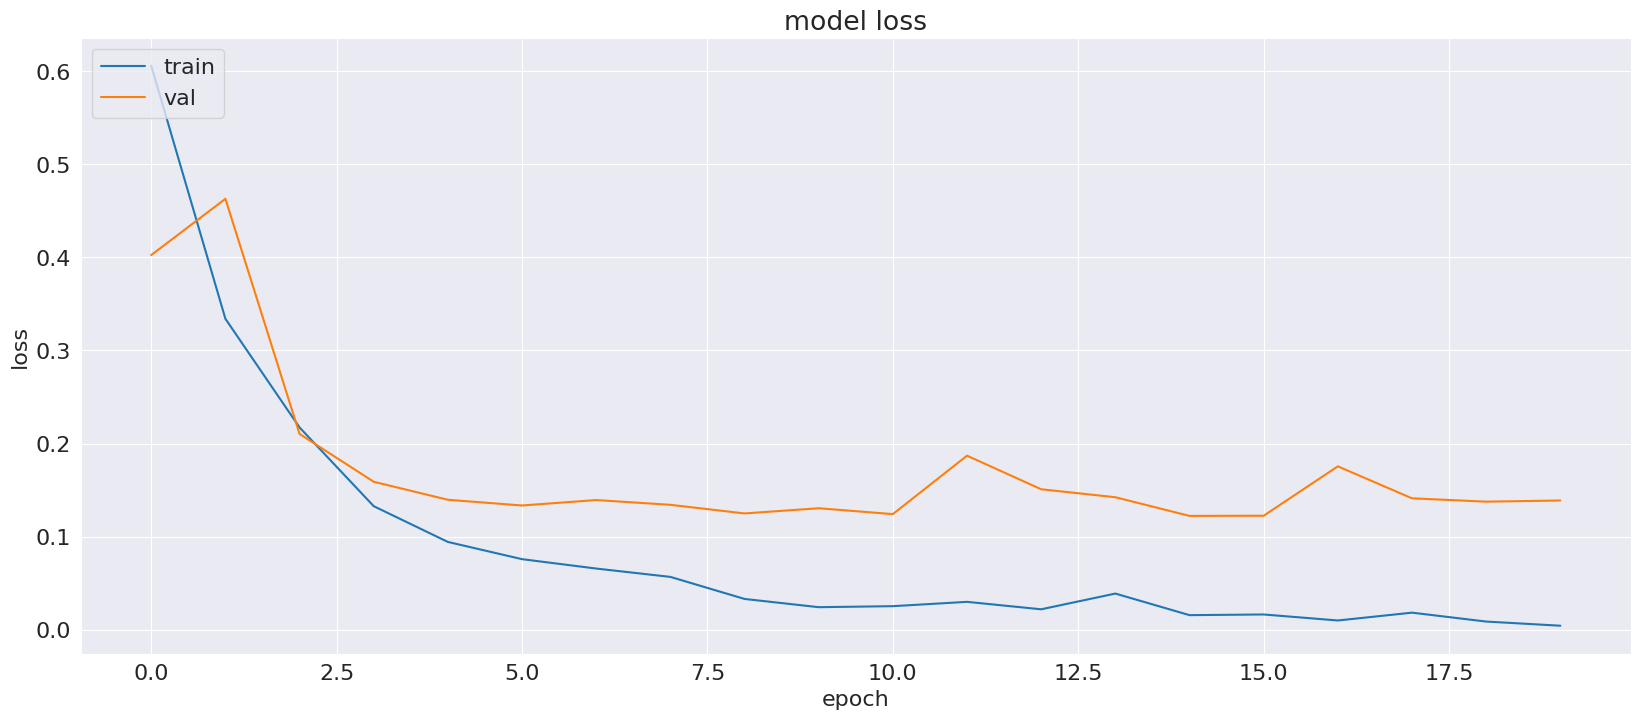

In [93]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

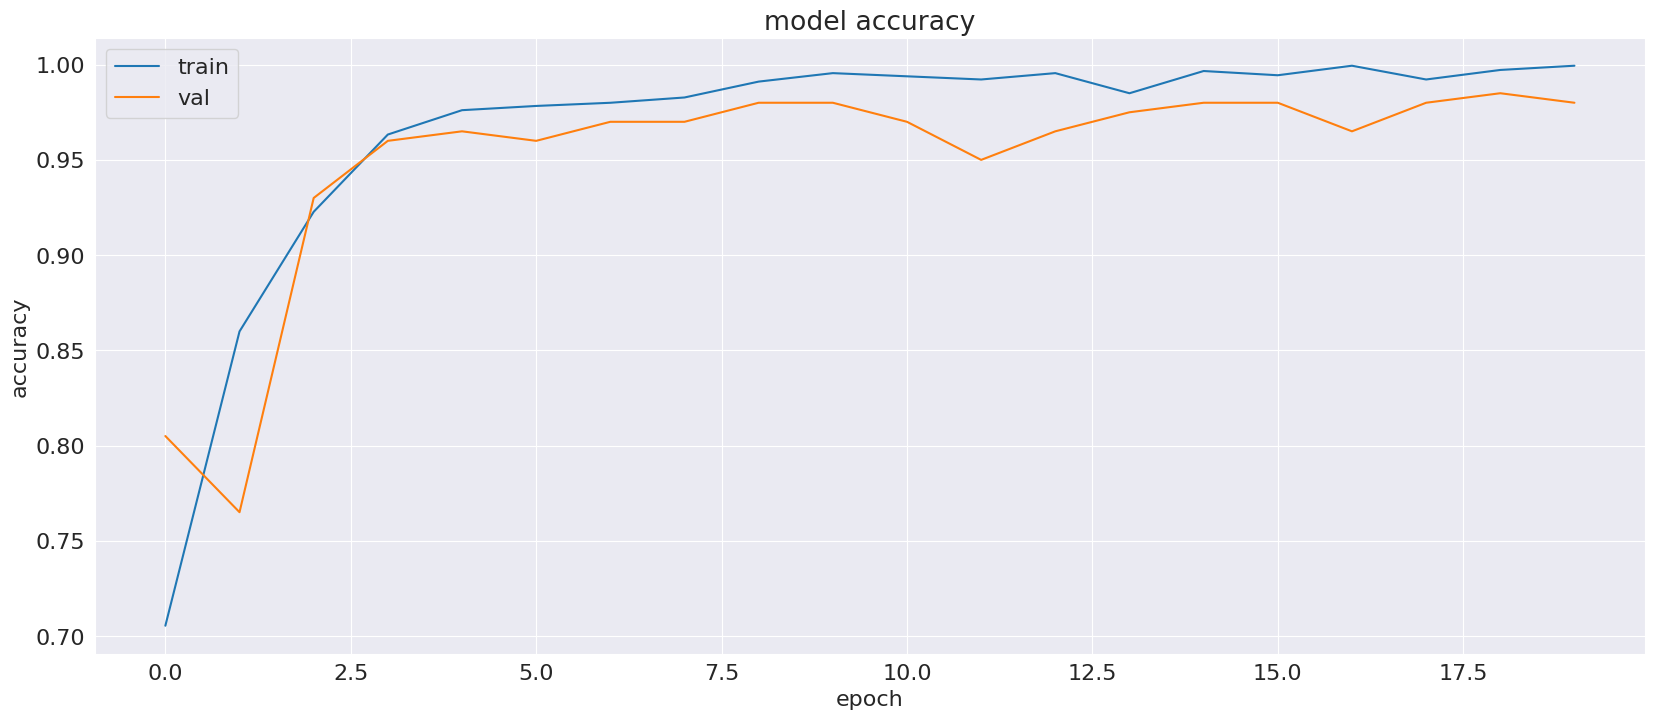

In [94]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [106]:
y_pred = model.predict(X_test)

7/7 [==============================] - 0s 4ms/step


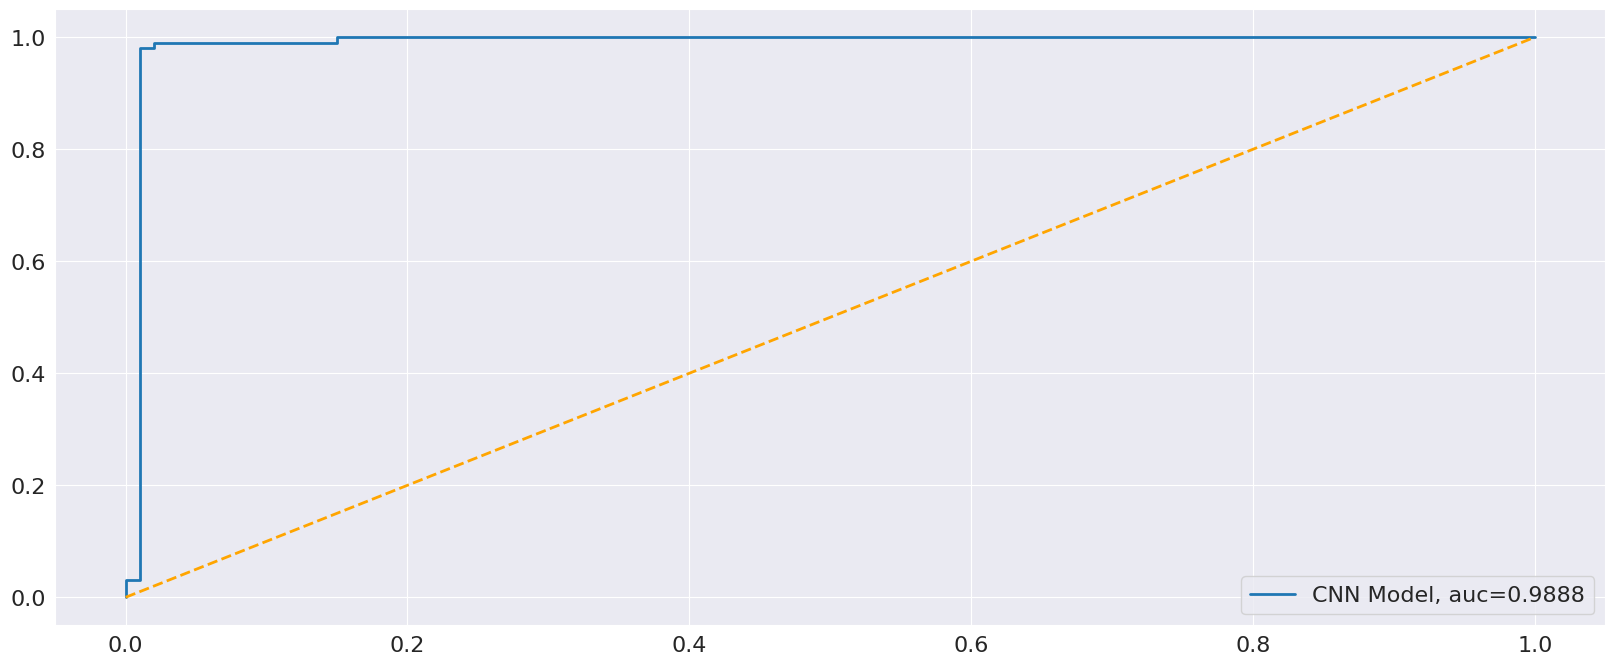

In [107]:
plt.figure(figsize=(20,8))
fpr, tpr, _ = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="CNN Model, auc="+str(auc),lw=2)
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.legend(loc=4)
plt.show()

In [108]:
y_pred[y_pred>=0.5] = 1
y_pred[y_pred<0.5] = 0

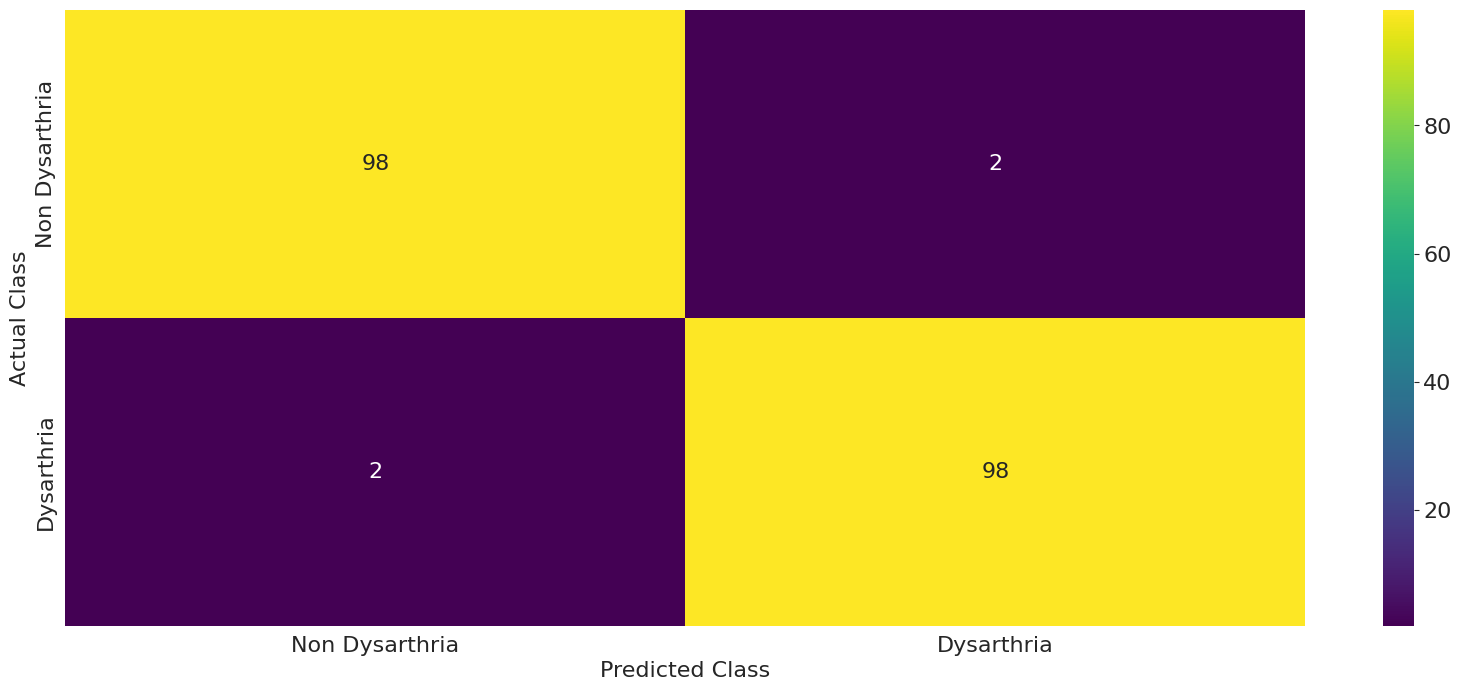

In [110]:
sns.heatmap(confusion_matrix(y_test, y_pred),cmap='viridis',annot=True,fmt='.3g',
            xticklabels=['Non Dysarthria','Dysarthria'],yticklabels=['Non Dysarthria','Dysarthria'])
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

In [111]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       100
         1.0       0.98      0.98      0.98       100

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200



In [112]:
print("Recall Score of the Model: ",recall_score(y_test,y_pred))

Recall Score of the Model:  0.98
